# ML Insights : Drift Metrics

## Use Case  

This Notebook shows how to configure following Drift Metrics using ML Insights .

- KullbackLeibler , KolmogorovSmirnov , ChiSquare , JensenShannon , PopulationStabilityIndex 

## Note

- Supported Drift metric algorithm for Numerical feature which needs to define variable_type=VariableType.CONTINUOUS :
    - Kolmogorov Smirnov
    - Kullback Leibler Divergence
    - Jensen Shannon (JS)
    - Population Stability Index (PSI)
- Supported Drift metric algorithm for Categorical feature which needs to define variable_type=VariableType.NOMINAL :
    - Chi square Goodness of Fit Test
- To view the drift metrics user needs to pass a reference profile to Profile API method ie to_json() , to_pandas() .
    - Eg. result =  base_profile.to_json(reference_profile=reference_profile_data)

### About Dataset 

The data was collected and made available by “National Institute of Diabetes and Digestive and Kidney Diseases” as part of the Pima Indians Diabetes Database. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here belong to the Pima Indian heritage (subgroup of Native Americans), and are females of ages 21 and above.

The data set contains medical and demographic data of patients . It consists of various features such as Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome, Prediction, BMICategory, Prediction_Score .

Dataset source : https://www.kaggle.com/datasets/kandij/diabetes-dataset


# Install ML Observability Insights Library SDK

- Prerequisites
    - Linux/Mac (Intel CPU)
    - Python 3.8 and 3.9 only


- Installation
    - ML Insights is made available as a Python package (via Artifactory) which can be installed using pip install as shown below. Depending on the execution engine on which to do the run, one can use scoped package. For eg: if we want to run on dask, use oracle-ml-insights[dask], for spark use oracle-ml-insights[spark], for native use oracle-ml-insights. One can install all the dependencies as use oracle-ml-insights[all]

      !pip install oracle-ml-insights


Refer : [Installation and Setup](https://docs.oracle.com/en-us/iaas/tools/ml-insights-docs/latest/ml-insights-documentation/html/user_guide/tutorials/install.html)

In [ ]:
!python3 -m pip install oracle-ml-insights

In [ ]:
!python3 -m pip install matplotlib

# 1 ML Insights Imports 

In [24]:
# imports

import os
from typing import Any
import pyarrow as pa
import pandas as pd
import json

# Import Data Quality metrics 
from mlm_insights.core.metrics.min import Min
from mlm_insights.core.metrics.mean import Mean


# Import Data Integrity metrics
from mlm_insights.core.metrics.rows_count import RowCount


# Import drift detection metrics
from mlm_insights.core.metrics.drift_metrics.chi_square import ChiSquare
from mlm_insights.core.metrics.drift_metrics.population_stability_index import PopulationStabilityIndex
from mlm_insights.core.metrics.drift_metrics.jensen_shannon import JensenShannon
from mlm_insights.core.metrics.drift_metrics.kullback_leibler import KullbackLeibler
from mlm_insights.core.metrics.drift_metrics.kolmogorov_smirnov import KolmogorovSmirnov


from mlm_insights.builder.builder_component import MetricDetail, EngineDetail
from mlm_insights.constants.types import FeatureType, DataType, VariableType, ColumnType
from mlm_insights.core.metrics.metric_metadata import MetricMetadata
from mlm_insights.builder.insights_builder import InsightsBuilder
from mlm_insights.core.post_processors.local_writer_post_processor import LocalWriterPostProcessor


# import data reader
from mlm_insights.core.data_sources import LocalDatePrefixDataSource
from mlm_insights.mlm_native.readers import CSVNativeDataReader

# 2 Configure Feature schema

Feature Schema defines the structure and metadata of the input data, which includes data type, column type, column mapping . The framework, uses this information as the ground truth and any deviation in the actual data is taken as an anomaly and the framework usually will ignore such all such anomaly in data.

In [25]:
def get_input_schema():
    return {
        "Pregnancies": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "BloodPressure": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "SkinThickness": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "Insulin": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "BMI": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "Age": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "DiabetesPedigreeFunction": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "Outcome": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS,column_type = ColumnType.TARGET),
        "Prediction": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS,column_type = ColumnType.PREDICTION),
        "BMICategory":FeatureType(data_type=DataType.STRING, variable_type=VariableType.NOMINAL)
        
    }



# 3 Configure Metrics

Metrics are the core construct for the framework. This component is responsible for calculating all statistical metrics and algorithms. Metric components work based on the type of features (eg. input feature, output feature etc.) available, their data type (eg. int, float, string etc.) as well as additional context (e.g. if any previous computation is available to compare against). ML Insights provides commonly used metrics out of the box for different ML observability use cases.

Refer : [Metrics Component Documentation](https://docs.oracle.com/en-us/iaas/tools/ml-insights-docs/latest/ml-insights-documentation/html/user_guide/getting_started/metrics_component.html)



In [26]:
def get_metrics():
    metrics = [
               MetricMetadata(klass=Mean),
               MetricMetadata(klass=Min)
              ]
    uni_variate_metrics = {
        "BloodPressure": metrics,
        "BMI": [MetricMetadata(klass=PopulationStabilityIndex),
               MetricMetadata(klass=JensenShannon),
               MetricMetadata(klass=KullbackLeibler),
               MetricMetadata(klass=KolmogorovSmirnov)],
        "BMICategory": [MetricMetadata(klass=ChiSquare)]
        
    }
    metric_details = MetricDetail(univariate_metric=uni_variate_metrics,
                                  dataset_metrics=[MetricMetadata(klass=RowCount)])
    return metric_details

# 4 Configure Data Reader

Data Reader allows for ingestion of raw data into the framework. This component is primarily responsible for understanding different formats of data (e.g. jsonl, csv) etc. and how to properly read them. At its essence, the primary responsibility of this component is that given a set of valid file locations which represents file of a specific type, reader can properly decode the content and load them in memory.

Additionally, Data Source component is an optional subcomponent, which is usually used along side the Reader. The primary responsibility of the data source component is to embed logic on filtering and partitioning of files to be read by the framework.

Refer : [Data Reader Documentation](https://docs.oracle.com/en-us/iaas/tools/ml-insights-docs/latest/ml-insights-documentation/html/user_guide/getting_started/data_reader_component.html)

In [27]:
def get_data_reader(start_date, end_date):
    
    # Define Data Format
    data = {
        "file_type": "csv",
        "date_range": {"start": start_date, "end": end_date}
    }
    
    # Define Data Location
    base_location ="input_data/diabetes_prediction"
    
    # Create new Dataset
    ds = LocalDatePrefixDataSource(base_location, **data)
    
    # Load Dataset
    csv_reader = CSVNativeDataReader(data_source=ds)
    
    
    return csv_reader

# 5 Compute the Profile 

Create the builder object which provides core set of api, using which user can set the behavior of their monitoring. By selecting what components and variants to run all aspects of the monitoring task can be customised and configured. 

The run() method is responsible to run the internal workflow. It also handles the life cycle of each component passed, which includes creation (if required), invoking interface functions, destroying etc . Additionally, runner also handles some more advanced operations like thread pooling, compute engine abstraction etc.

Refer : [Builder Object Documentation](https://docs.oracle.com/en-us/iaas/tools/ml-insights-docs/latest/ml-insights-documentation/html/user_guide/getting_started/builder_object.html)


In [28]:

 
# Create the ML Monitoring Metrics
def run_evaluation(start_date, end_date, output_location, output_file):    
    
    # Set up the insights builder by passing: input schema, metric, reader and engine details
    runner = InsightsBuilder(). \
        with_input_schema(get_input_schema()). \
        with_metrics(metrics=get_metrics()). \
        with_reader(reader=get_data_reader(start_date, end_date)). \
        with_post_processors(post_processors=[LocalWriterPostProcessor(file_location=output_location, file_name=output_file)]). \
        build()

    # Run the Evaluation of Metrics
    run_result = runner.run()
    
    return run_result.profile
    

In [29]:
# Define Baseline Dates
base_start_date = '2023-06-26'
base_end_date = '2023-06-26'

# Execute Base Profile - Pass in Data Start, Data End, Output Location, Output File
base_profile = run_evaluation(base_start_date, base_end_date, 'output_data/profiles', 'base_profile.bin')

In [30]:

# Extract Feature Results
base_feature_results = base_profile.to_json()['feature_metrics']

# Convert to Pandas DF
base_feature_results = pd.json_normalize(base_feature_results)

# Add Column with Date and Type
base_feature_results['Prediction_Date'] = base_start_date
base_feature_results['Metric_Type'] = 'Baseline'

# Preview Data
base_feature_results.head()

,BloodPressure.Mean.metric_name,BloodPressure.Mean.metric_description,BloodPressure.Mean.variable_count,BloodPressure.Mean.variable_names,BloodPressure.Mean.variable_types,BloodPressure.Mean.variable_dtypes,BloodPressure.Mean.variable_dimensions,BloodPressure.Mean.metric_data,BloodPressure.Min.metric_name,BloodPressure.Min.metric_description,...,BMI.PopulationStabilityIndex.metric_description,BMI.PopulationStabilityIndex.error,BMI.KolmogorovSmirnov.metric_name,BMI.KolmogorovSmirnov.metric_description,BMI.KolmogorovSmirnov.error,BMICategory.ChiSquare.metric_name,BMICategory.ChiSquare.metric_description,BMICategory.ChiSquare.error,Prediction_Date,Metric_Type
0,Mean,Feature Metric to compute mean,1,[mean],[CONTINUOUS],[FLOAT],[0],[69.13432835820896],Min,Feature Metric to compute minimum value,...,Data Drift Metric to compute Population Stabil...,Missing required parameter profile or registry...,KolmogorovSmirnov,Data Drift Metric to compute two-sample Kolmog...,Missing required parameter profile or registry...,ChiSquare,Data Drift Metric to compute Chi-square goodne...,Missing required parameter Reference profile i...,2023-06-26,Baseline


In [31]:
# Extract Model Metrics Results
base_dataset_results = base_profile.to_json()['dataset_metrics']

# Convert to Pandas DF
base_dataset_results = pd.json_normalize(base_dataset_results)

# Add Column with Date and Type
base_dataset_results['Prediction_Date'] = base_start_date
base_dataset_results['Metric_Type'] = 'Baseline'

# Preview Data
base_dataset_results.head()

,RowCount.metric_name,RowCount.metric_description,RowCount.variable_count,RowCount.variable_names,RowCount.variable_types,RowCount.variable_dtypes,RowCount.variable_dimensions,RowCount.metric_data,Prediction_Date,Metric_Type
0,RowCount,Dataset-level Metric to compute the total row ...,1,[rows_count],[DISCRETE],[INTEGER],[0],[469.0],2023-06-26,Baseline


# 6 Compute the Reference Profile for Drift Metrics 

In [32]:
# Define a list of reference datasets
reference_datasets = ['2023-06-27', '2023-06-28', '2023-06-29']

# Define Results DFs
reference_feature_results_df = pd.DataFrame()
reference_dataset_results_df = pd.DataFrame()

reference_profile_list = []

# Iterate over each reference dataset
for dataset in reference_datasets:
    
    # Define Dates
    start_date = dataset
    end_date = dataset
    output_file = 'reference_profile_' + dataset + '.bin'
    
    # Execute Reference Profile - Pass in Data Start, Data End, Output Location, Output File
    reference_profile_data = run_evaluation(start_date, end_date, 'output_data/profiles', output_file)
    # reference_profile_list.append(reference_profile)
    # print(reference_profile_list)
    reference_profile = base_profile.to_json(reference_profile=reference_profile_data)
    reference_profile_list.append(reference_profile)
    
    ################################## Parse Feature Metrics ##################################
    # Extract Feature Results and Convert to Pandas
    reference_feature_results = reference_profile['feature_metrics']
    reference_feature_results = pd.json_normalize(reference_feature_results)
    
    # Add Column with Date and Type
    reference_feature_results['Prediction_Date'] = dataset
    reference_feature_results['Metric_Type'] = 'Reference'
    
    # Append to Results DF
    reference_feature_results_df = pd.concat([reference_feature_results_df, reference_feature_results])
    
    ################################## Parse Dataset Metrics ##################################
    
    # Extract Model Metrics and Convert to Pandas
    reference_dataset_results = reference_profile['dataset_metrics']
    reference_dataset_results = pd.json_normalize(reference_dataset_results)
    
    # Add Column with Data and Type
    reference_dataset_results['Prediction_Date'] = dataset
    reference_dataset_results['Metric_Type'] = 'Reference'
    
    # Append to Results DF
    reference_dataset_results_df = pd.concat([reference_dataset_results_df, reference_dataset_results])
    

# 7 Result

In [33]:


profile_json_0 = reference_profile_list[0]
# profile_json_0 = base_profile.to_json(reference_profile=profile_temp)
pd.json_normalize(profile_json_0).T.dropna()

,0
dataset_metrics.RowCount.metric_name,RowCount
dataset_metrics.RowCount.metric_description,Dataset-level Metric to compute the total row ...
dataset_metrics.RowCount.variable_count,1
dataset_metrics.RowCount.variable_names,[rows_count]
dataset_metrics.RowCount.variable_types,[DISCRETE]
...,...
feature_metrics.BMICategory.ChiSquare.variable_names,"[algorithm, test_statistic, p_value]"
feature_metrics.BMICategory.ChiSquare.variable_types,"[TEXT, CONTINUOUS, CONTINUOUS]"
feature_metrics.BMICategory.ChiSquare.variable_dtypes,"[STRING, FLOAT, FLOAT]"
feature_metrics.BMICategory.ChiSquare.variable_dimensions,"[0, 0, 0]"


In [34]:
profile_json_1 = reference_profile_list[1]
# profile_json_1 = base_profile.to_json(reference_profile=profile_temp)
pd.json_normalize(profile_json_1).T.dropna()

,0
dataset_metrics.RowCount.metric_name,RowCount
dataset_metrics.RowCount.metric_description,Dataset-level Metric to compute the total row ...
dataset_metrics.RowCount.variable_count,1
dataset_metrics.RowCount.variable_names,[rows_count]
dataset_metrics.RowCount.variable_types,[DISCRETE]
...,...
feature_metrics.BMICategory.ChiSquare.variable_names,"[algorithm, test_statistic, p_value]"
feature_metrics.BMICategory.ChiSquare.variable_types,"[TEXT, CONTINUOUS, CONTINUOUS]"
feature_metrics.BMICategory.ChiSquare.variable_dtypes,"[STRING, FLOAT, FLOAT]"
feature_metrics.BMICategory.ChiSquare.variable_dimensions,"[0, 0, 0]"


In [35]:
profile_json_2 = reference_profile_list[2]
# profile_json_2 = base_profile.to_json(reference_profile=profile_temp)
pd.json_normalize(profile_json_2).T.dropna()

,0
dataset_metrics.RowCount.metric_name,RowCount
dataset_metrics.RowCount.metric_description,Dataset-level Metric to compute the total row ...
dataset_metrics.RowCount.variable_count,1
dataset_metrics.RowCount.variable_names,[rows_count]
dataset_metrics.RowCount.variable_types,[DISCRETE]
...,...
feature_metrics.BMICategory.ChiSquare.variable_names,"[algorithm, test_statistic, p_value]"
feature_metrics.BMICategory.ChiSquare.variable_types,"[TEXT, CONTINUOUS, CONTINUOUS]"
feature_metrics.BMICategory.ChiSquare.variable_dtypes,"[STRING, FLOAT, FLOAT]"
feature_metrics.BMICategory.ChiSquare.variable_dimensions,"[0, 0, 0]"


In [36]:
# Concatentate Both Base and Reference Dataset
ml_monitoring_features_df = pd.concat([base_feature_results, reference_feature_results_df])
ml_monitoring_dataset_df = pd.concat([base_dataset_results, reference_dataset_results_df])

In [37]:
# Preview Data
ml_monitoring_features_df.head()

,BloodPressure.Mean.metric_name,BloodPressure.Mean.metric_description,BloodPressure.Mean.variable_count,BloodPressure.Mean.variable_names,BloodPressure.Mean.variable_types,BloodPressure.Mean.variable_dtypes,BloodPressure.Mean.variable_dimensions,BloodPressure.Mean.metric_data,BloodPressure.Min.metric_name,BloodPressure.Min.metric_description,...,BMI.KolmogorovSmirnov.variable_types,BMI.KolmogorovSmirnov.variable_dtypes,BMI.KolmogorovSmirnov.variable_dimensions,BMI.KolmogorovSmirnov.metric_data,BMICategory.ChiSquare.variable_count,BMICategory.ChiSquare.variable_names,BMICategory.ChiSquare.variable_types,BMICategory.ChiSquare.variable_dtypes,BMICategory.ChiSquare.variable_dimensions,BMICategory.ChiSquare.metric_data
0,Mean,Feature Metric to compute mean,1,[mean],[CONTINUOUS],[FLOAT],[0],[69.13432835820896],Min,Feature Metric to compute minimum value,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Mean,Feature Metric to compute mean,1,[mean],[CONTINUOUS],[FLOAT],[0],[69.13432835820896],Min,Feature Metric to compute minimum value,...,"[TEXT, CONTINUOUS, CONTINUOUS]","[STRING, FLOAT, FLOAT]","[0, 0, 0]","[Kolmogorov Smirnov, 0.0, 1.0]",3.0,"[algorithm, test_statistic, p_value]","[TEXT, CONTINUOUS, CONTINUOUS]","[STRING, FLOAT, FLOAT]","[0, 0, 0]","[Chi Squared Goodness of Fit Test, 0.0, 1.0]"
0,Mean,Feature Metric to compute mean,1,[mean],[CONTINUOUS],[FLOAT],[0],[69.13432835820896],Min,Feature Metric to compute minimum value,...,"[TEXT, CONTINUOUS, CONTINUOUS]","[STRING, FLOAT, FLOAT]","[0, 0, 0]","[Kolmogorov Smirnov, 0.023727808626842872, 0.9...",3.0,"[algorithm, test_statistic, p_value]","[TEXT, CONTINUOUS, CONTINUOUS]","[STRING, FLOAT, FLOAT]","[0, 0, 0]","[Chi Squared Goodness of Fit Test, 0.792850722..."
0,Mean,Feature Metric to compute mean,1,[mean],[CONTINUOUS],[FLOAT],[0],[69.13432835820896],Min,Feature Metric to compute minimum value,...,"[TEXT, CONTINUOUS, CONTINUOUS]","[STRING, FLOAT, FLOAT]","[0, 0, 0]","[Kolmogorov Smirnov, 0.023727808626842872, 0.9...",3.0,"[algorithm, test_statistic, p_value]","[TEXT, CONTINUOUS, CONTINUOUS]","[STRING, FLOAT, FLOAT]","[0, 0, 0]","[Chi Squared Goodness of Fit Test, 0.792850722..."


In [38]:
import numpy as np

def extract_val(val, idx):
    return val.transform(lambda x: x[idx])

In [39]:
plot_df = ml_monitoring_features_df[[   
    'Prediction_Date', 
    'BMI.JensenShannon.metric_data', 
    'BMI.KullbackLeibler.metric_data', 
    'BMI.PopulationStabilityIndex.metric_data',
    'BMI.KolmogorovSmirnov.metric_data',
    'BMICategory.ChiSquare.metric_data'
    ]]
plot_df = plot_df.dropna()
plot_df

,Prediction_Date,BMI.JensenShannon.metric_data,BMI.KullbackLeibler.metric_data,BMI.PopulationStabilityIndex.metric_data,BMI.KolmogorovSmirnov.metric_data,BMICategory.ChiSquare.metric_data
0,2023-06-27,"[Jensen Shannon Distance, 0.04097303379414298]","[Kullback Leibler Divergence, 0.00459106385283...","[Population Stability Index, 0.017235725022476...","[Kolmogorov Smirnov, 0.0, 1.0]","[Chi Squared Goodness of Fit Test, 0.0, 1.0]"
0,2023-06-28,"[Jensen Shannon Distance, 0.07587858541090198]","[Kullback Leibler Divergence, 0.02110447735764...","[Population Stability Index, 0.05470052768946404]","[Kolmogorov Smirnov, 0.023727808626842872, 0.9...","[Chi Squared Goodness of Fit Test, 0.792850722..."
0,2023-06-29,"[Jensen Shannon Distance, 0.08275482217711765]","[Kullback Leibler Divergence, 0.03265104984406...","[Population Stability Index, 0.06876516334077673]","[Kolmogorov Smirnov, 0.023727808626842872, 0.9...","[Chi Squared Goodness of Fit Test, 0.792850722..."


In [40]:
x = plot_df['Prediction_Date']
x1 = extract_val(plot_df['BMI.JensenShannon.metric_data'], 1)
x2 = extract_val(plot_df['BMI.KullbackLeibler.metric_data'], 1)
x3 = extract_val(plot_df['BMI.PopulationStabilityIndex.metric_data'], 1)
x4 = extract_val(plot_df['BMI.KolmogorovSmirnov.metric_data'], 1)

chi = plot_df['BMICategory.ChiSquare.metric_data']
x5 = chi.transform(lambda x: x[1])

x5 = extract_val(plot_df['BMICategory.ChiSquare.metric_data'], 1)

drift_metrics = pd.concat([x, x1, x2, x3, x4, x5], axis = 1)
drift_metrics

,Prediction_Date,BMI.JensenShannon.metric_data,BMI.KullbackLeibler.metric_data,BMI.PopulationStabilityIndex.metric_data,BMI.KolmogorovSmirnov.metric_data,BMICategory.ChiSquare.metric_data
0,2023-06-27,0.040973,0.004591,0.017236,0.000000,0.000000
0,2023-06-28,0.075879,0.021104,0.054701,0.023728,0.792851
0,2023-06-29,0.082755,0.032651,0.068765,0.023728,0.792851


In [41]:
# js = pd.concat([x, x1], axis = 1)
# js.plot('Prediction_Date', 'BMI.JensenShannon.metric_data')

# kl =  pd.concat([x, x2], axis = 1)
# kl.plot('Prediction_Date','BMI.KullbackLeibler.metric_data')

# psi  = pd.concat([x, x3], axis = 1)
# psi.plot('Prediction_Date','BMI.PopulationStabilityIndex.metric_data')

# ks = pd.concat([x, x4], axis = 1)
# ks.plot('Prediction_Date','BMI.KolmogorovSmirnov.metric_data')

# chi = pd.concat([x, x5], axis = 1)
# chi.plot('Prediction_Date','BMICategory.ChiSquare.metric_data')

<Axes: title={'center': 'Drift Metrics'}, xlabel='Prediction_Date'>

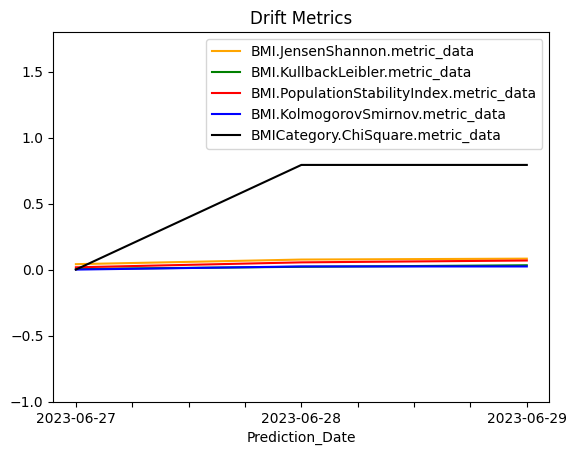

In [42]:
drift_metrics = drift_metrics.set_index('Prediction_Date')
drift_metrics.plot(kind='line', color=['orange', 'green', 'red', 'blue', 'black'], title = 'Drift Metrics',  ylim=(-1, 1.8))